In [2]:
import pandas as pd
#%matplotlib notebook
from matplotlib import pyplot as plt
import numpy as np
import glob
from sklearn import preprocessing
import seaborn as sns
import matplotlib.dates as mdates

**DATA8 - Statistics for Machine Learning - part 3**

**Une timeserie, c'est quoi ?**
Tout simplement, un dataset dont les valeurs sont mesurées à différents points dans le temps.
Comme il s’agit d’évaluer l’évolution d’un phénomène au cours du temps, l’ordre est ici très important.

**Pourquoi une partie dédiée aux séries temporelles ?**
- Elles sont présentes dans de nombreux domaines d’application
- Elles permettent de comprendre les tendances passées / d'estimer les comportements futurs
- Pandas offre tout un panel d'outils qui simplifient énormément la manipulation de séries temporelles

**Ressources:**
- https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
- https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html
- https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DatetimeIndex.html

**What you will see today: Timeseries analysis**
1. Basics of timeseries with Pandas
2. Identifying Patterns in Time Series: Trend, seasonality, noise
3. Autocorrelation
4. Spectral analsis (fft)

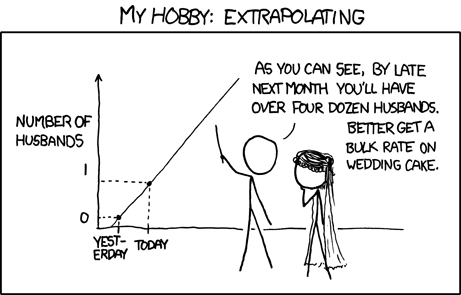

In [1]:
from IPython.display import Image
Image('IMG/xkcd_extrapolating.png', width=400)

# Working with timestamps

**TODO**
<font color=#cc0066>
        
- Charger les données précédentes.  
- Se familiariser avec les outils de Pandas dédiés à la manipulation des dates:
    - https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
    - les méthodes: to_datetime, date_range, period_range, timedelta_range, min, max, shift, resample, rolling, ...
    - la gestion des timezone: tz_localize, tz_convert
    - les offsets
    
</font>

In [128]:
#Fichiers nationaux
path='../DATA/data_RTE/conso' # use your path
fichier_nationaux = glob.glob(path + "/eCO2mix_RTE_Annuel-Definitif*.zip")

li = []

for filename in fichier_nationaux:
    df = pd.read_csv(filename, sep='\t' , encoding='latin_1', index_col = False,na_values='ND')
    li.append(df)

df_national = pd.concat(li, axis=0, ignore_index=True,sort=False)

df_national['Datetime']=df_national['Date']+' '+df_national['Heures']
df_national['Datetime']=pd.to_datetime(df_national['Datetime'])
df_national.index=df_national['Datetime']
df_national=df_national.drop(['Date', 'Heures','Périmètre','Nature','Datetime'], axis=1)

df_national.index=df_national.index.tz_localize('CET',ambiguous='NaT',nonexistent='NaT')
df_national.sort_index(inplace=True)

In [25]:
#Fichiers régionaux
path='../DATA/data_RTE/conso' # use your path
fichier_regionaux = glob.glob(path + "/eCO2mix_RTE_*.zip")

for file in fichier_nationaux:
    if file in fichier_regionaux:
        fichier_regionaux.remove(file)

li = []

for filename in fichier_regionaux:
    df = pd.read_csv(filename, sep='\t' , encoding='latin_1', index_col = False, na_values=['ND','nan','-'])
    li.append(df)

df_regional = pd.concat(li, axis=0, ignore_index=True,sort=False)

df_regional['Datetime']=df_regional['Date']+' '+df_regional['Heures']
df_regional['Datetime']=pd.to_datetime(df_regional['Datetime'])
df_regional.index=df_regional['Datetime']
df_regional=df_regional.drop(['Date', 'Heures','Nature','Datetime'], axis=1)
df_regional.drop(df_regional.tail(1).index,inplace=True)

df_regional.index=df_regional.index.tz_localize('CET',ambiguous='NaT',nonexistent='NaT')

## Interpolation

**TODO**
<font color=#cc0066>
        
- Les données de consommation sont fournies toutes les 30 minutes, celles correspondants aux prévisions J-1 sont fournies tous les 1/4 d'heures. Utiliser les différentes fonction d'interpolation offertes par Pandas, en observant les résultats (head et plot).    
    
</font>

If we want to mean interpolate the missing values, we need to do this in two steps. First, we generate the data grid by using mean() to generate NaNs. Afterwards we fill the NaNs by interpolated values by calling the interpolate() method on the readvalue column.

It seems that our data have already NaNs every 15 minutes, so mean() in not necessary.

In [34]:
df_national.columns

Index(['Consommation', 'Prévision J-1', 'Prévision J', 'Fioul', 'Charbon',
       'Gaz', 'Nucléaire', 'Eolien', 'Solaire', 'Hydraulique', 'Pompage',
       'Bioénergies', 'Ech. physiques', 'Taux de Co2', 'Ech. comm. Angleterre',
       'Ech. comm. Espagne', 'Ech. comm. Italie', 'Ech. comm. Suisse',
       'Ech. comm. Allemagne-Belgique', 'Fioul - TAC', 'Fioul - Cogén.',
       'Fioul - Autres', 'Gaz - TAC', 'Gaz - Cogén.', 'Gaz - CCG',
       'Gaz - Autres', 'Hydraulique - Fil de l?eau + éclusée',
       'Hydraulique - Lacs', 'Hydraulique - STEP turbinage',
       'Bioénergies - Déchets', 'Bioénergies - Biomasse',
       'Bioénergies - Biogaz'],
      dtype='object')

In [47]:
df_national.head(4)

,Consommation,Prévision J-1,Prévision J,Fioul,Charbon,Gaz,Nucléaire,Eolien,Solaire,Hydraulique,...,Gaz - TAC,Gaz - Cogén.,Gaz - CCG,Gaz - Autres,Hydraulique - Fil de l?eau + éclusée,Hydraulique - Lacs,Hydraulique - STEP turbinage,Bioénergies - Déchets,Bioénergies - Biomasse,Bioénergies - Biogaz
Datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+01:00,74494.0,72900.0,73700.0,269.0,2487.0,3476.0,57982.0,1268.0,0.0,9321.0,...,3.0,2056.0,1350.0,66.0,4810.0,3093.0,1418.0,560.0,181.0,197.0
2015-01-01 00:15:00+01:00,NaN,72250.0,73050.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:30:00+01:00,73481.0,71600.0,72400.0,319.0,2087.0,2691.0,57856.0,1343.0,-1.0,9664.0,...,9.0,1926.0,670.0,86.0,4616.0,3561.0,1487.0,507.0,180.0,210.0
2015-01-01 00:45:00+01:00,NaN,70750.0,71500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


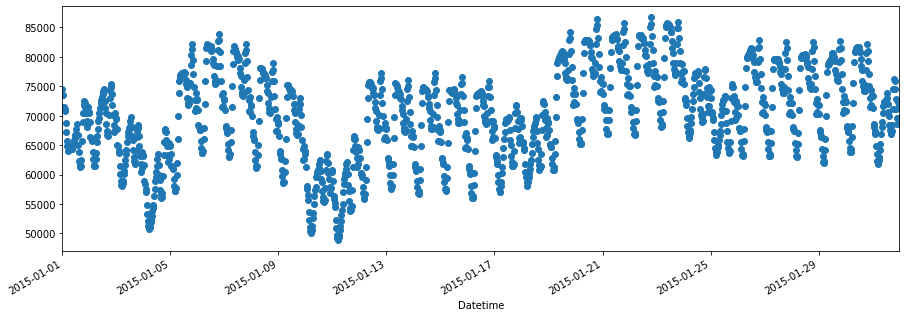

In [43]:
df_national.loc['2015-01'].Consommation.plot(marker='o',figsize=(15,5))

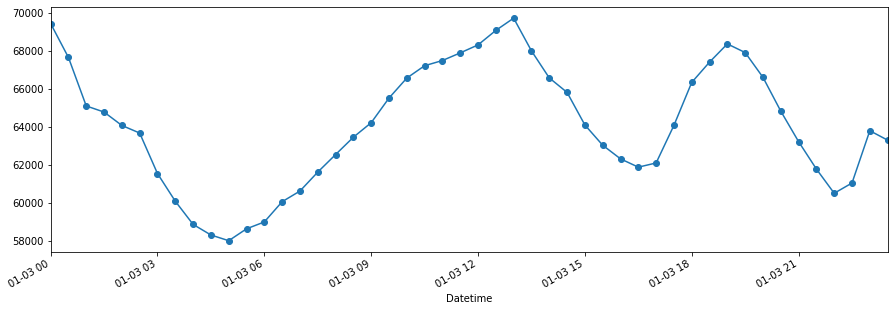

In [51]:
df_national.loc['2015-01-03'].Consommation.dropna().plot(marker='o',figsize=(15,5))

In [46]:
df_national_i=df_national.copy()
df_national_i = df_national_i.interpolate()
df_national_i.head(4)

,Consommation,Prévision J-1,Prévision J,Fioul,Charbon,Gaz,Nucléaire,Eolien,Solaire,Hydraulique,...,Gaz - TAC,Gaz - Cogén.,Gaz - CCG,Gaz - Autres,Hydraulique - Fil de l?eau + éclusée,Hydraulique - Lacs,Hydraulique - STEP turbinage,Bioénergies - Déchets,Bioénergies - Biomasse,Bioénergies - Biogaz
Datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+01:00,74494.0,72900.0,73700.0,269.0,2487.0,3476.0,57982.0,1268.0,0.0,9321.0,...,3.0,2056.0,1350.0,66.0,4810.0,3093.0,1418.0,560.0,181.0,197.0
2015-01-01 00:15:00+01:00,73987.5,72250.0,73050.0,294.0,2287.0,3083.5,57919.0,1305.5,-0.5,9492.5,...,6.0,1991.0,1010.0,76.0,4713.0,3327.0,1452.5,533.5,180.5,203.5
2015-01-01 00:30:00+01:00,73481.0,71600.0,72400.0,319.0,2087.0,2691.0,57856.0,1343.0,-1.0,9664.0,...,9.0,1926.0,670.0,86.0,4616.0,3561.0,1487.0,507.0,180.0,210.0
2015-01-01 00:45:00+01:00,72493.5,70750.0,71500.0,319.5,1901.5,2563.5,57821.5,1349.5,-1.0,9071.5,...,9.0,1922.5,546.0,86.0,4554.0,3183.0,1334.5,507.5,177.0,211.0


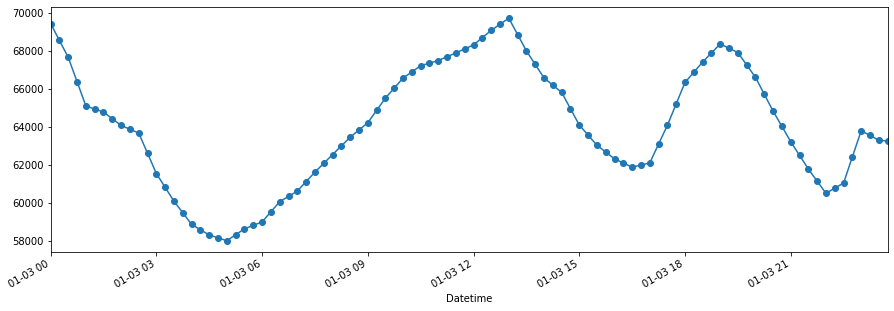

In [52]:
df_national_i.loc['2015-01-03'].Consommation.plot(marker='o',figsize=(15,5))

# Identifying paterns in the timeserie

## Trend, saisonality

Série temporelle = Tendance + Saisonnalité(s) + Bruit  <br/>
- Tendance: variations à long terme (tendance nulle = série stationnaire)
- Saisonnalité: variations périodiques
- Bruit: tendance nulle

On cherche ici à extraire la structure du signal, pour, par exemple:
- supprimer la partie bruitage, les erreurs de mesure ou les fluctuations non explicables
- supprimer des variations saisonnières pour évaluer des tendances
- projeter un comportement dans le futur
- ...

**Ressources:**
- un cours théorique: https://perso.math.univ-toulouse.fr/jydauxoi/files/2017/04/poly_eleves.pdf

**TODO**
<font color=#cc0066>
        
- Observer la courbe de consommation: quelle(s) composante(s) semblent saisonnières ? quelle tendance ?
- Faire de même avec les sources de production solaire et éolienne ?
- Faire apparaitre clairement ces "patterns" en utilisant les méthodes 'rolling' et 'resample'. Visualiser les différences entre les deux méthodes 
    
</font>

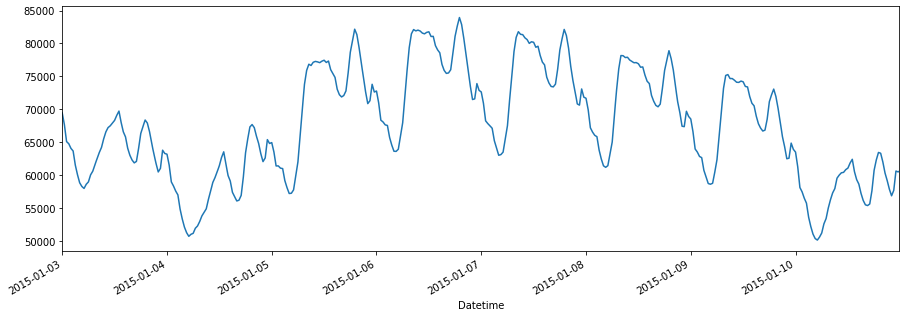

In [55]:
df_national_i.loc['2015-01-03':'2015-01-10'].Consommation.plot(figsize=(15,5))

TypeError: resample() got an unexpected keyword argument 'center'

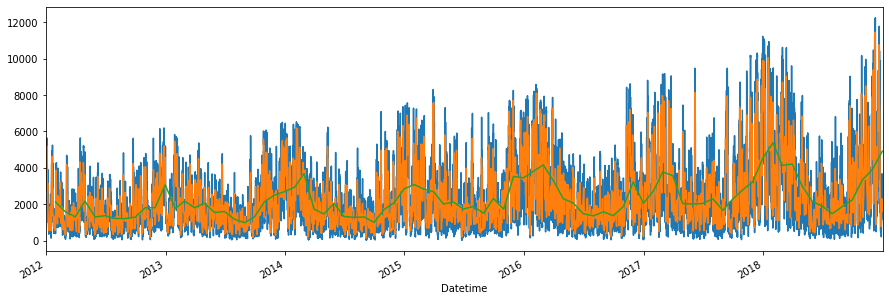

In [133]:
fig=plt.figure()
df_national_i.Eolien.resample('H').mean().plot(figsize=(15,5),label='hour')
df_national_i.Eolien.resample('D').mean().plot(figsize=(15,5),label='day')
df_national_i.Eolien.resample('M').mean().plot(figsize=(15,5),label='month')
df_national_i.Eolien.resample('Y',center=True).mean().plot(figsize=(15,5),label='year')
plt.legend()
plt.show()

In [132]:
df_national_i.Eolien.resample('Y').mean()

Datetime
2012-12-31 00:00:00+01:00    1696.514608
2013-12-31 00:00:00+01:00    1816.135438
2014-12-31 00:00:00+01:00    1947.507888
2015-12-31 00:00:00+01:00    2407.615375
2016-12-31 00:00:00+01:00    2381.035655
2017-12-31 00:00:00+01:00    2750.246365
2018-12-31 00:00:00+01:00    3211.240337
Name: Eolien, dtype: float64

/home/campus-5/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


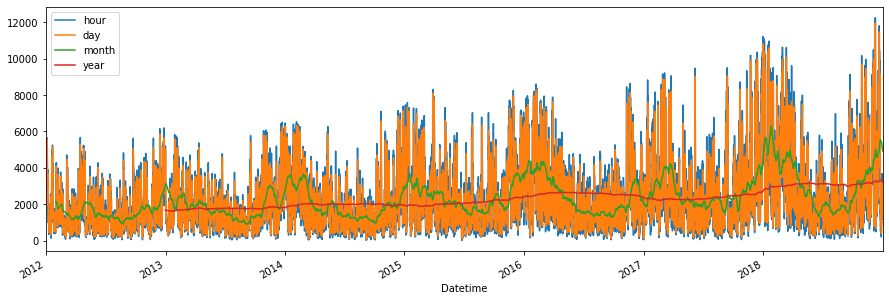

In [129]:
fig=plt.figure()
df_national_i.Eolien.rolling(4).mean().plot(figsize=(15,5),label='hour')
df_national_i.Eolien.rolling(48).mean().plot(figsize=(15,5),label='day')
df_national_i.Eolien.rolling(31*24*4).mean().plot(figsize=(15,5),label='month')
df_national_i.Eolien.rolling(365*24*4).mean().plot(figsize=(15,5),label='year')
plt.legend()

plt.show()

In [130]:
df_national_i.loc['2012'].Eolien.rolling(365*24*4).mean()#.plot(figsize=(15,5),label='year')

Datetime
2012-01-01 00:00:00+01:00            NaN
2012-01-01 00:15:00+01:00            NaN
2012-01-01 00:30:00+01:00            NaN
2012-01-01 00:45:00+01:00            NaN
2012-01-01 01:00:00+01:00            NaN
                                ...     
2012-12-31 22:45:00+01:00    1690.927041
2012-12-31 23:00:00+01:00    1690.935174
2012-12-31 23:15:00+01:00    1690.942352
2012-12-31 23:30:00+01:00    1690.948573
2012-12-31 23:45:00+01:00    1690.937219
Name: Eolien, Length: 35128, dtype: float64

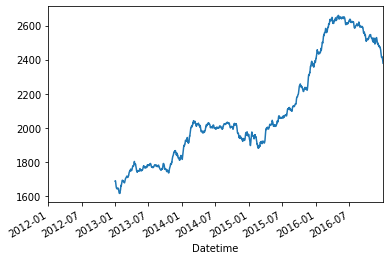

In [127]:
df_national_i.loc['2012':'2016'].Eolien.rolling(365*24*4).mean().plot()

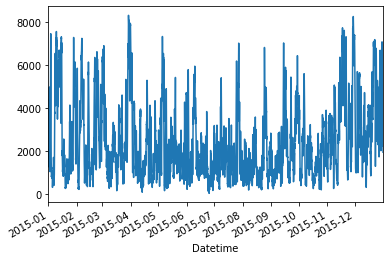

In [123]:
df_national_i.loc['2015'].Eolien.plot()

In [117]:
df_national_i.tail(10)

,Consommation,Prévision J-1,Prévision J,Fioul,Charbon,Gaz,Nucléaire,Eolien,Solaire,Hydraulique,...,Gaz - TAC,Gaz - Cogén.,Gaz - CCG,Gaz - Autres,Hydraulique - Fil de l?eau + éclusée,Hydraulique - Lacs,Hydraulique - STEP turbinage,Bioénergies - Déchets,Bioénergies - Biomasse,Bioénergies - Biogaz
Datetime,,,,,,,,,,,,,,,,,,,,,
2018-12-31 21:45:00+01:00,60240.5,59050.0,59600.0,158.0,11.5,3696.5,55541.5,1429.0,-2.0,4640.0,...,4.0,2496.5,1080.0,115.5,3839.0,802.0,0.0,556.0,314.0,295.5
2018-12-31 22:00:00+01:00,59901.0,58800.0,59400.0,146.0,11.0,3568.0,55404.0,1452.0,-2.0,4632.0,...,4.0,2496.0,950.0,117.0,3818.0,815.0,0.0,556.0,314.0,296.0
2018-12-31 22:15:00+01:00,60420.0,59700.0,60250.0,146.0,11.0,3727.0,55295.0,1510.5,-2.0,4541.5,...,4.0,2495.5,1109.5,117.5,3788.5,753.5,0.0,556.5,313.0,296.0
2018-12-31 22:30:00+01:00,60939.0,60600.0,61100.0,146.0,11.0,3886.0,55186.0,1569.0,-2.0,4451.0,...,4.0,2495.0,1269.0,118.0,3759.0,692.0,0.0,557.0,312.0,296.0
2018-12-31 22:45:00+01:00,62458.0,62050.0,62550.0,146.0,11.0,3898.0,55387.5,1553.0,-2.0,4799.5,...,4.0,2494.5,1282.5,117.0,3737.5,1062.0,0.0,557.0,315.0,296.0
2018-12-31 23:00:00+01:00,63977.0,63500.0,64000.0,146.0,11.0,3910.0,55589.0,1537.0,-2.0,5148.0,...,4.0,2494.0,1296.0,116.0,3716.0,1432.0,0.0,557.0,318.0,296.0
2018-12-31 23:15:00+01:00,63890.0,63750.0,64300.0,146.0,11.5,3681.0,55496.5,1540.0,-2.0,4918.0,...,4.0,2482.0,1079.5,115.5,3623.5,1294.5,0.0,557.0,317.0,294.5
2018-12-31 23:30:00+01:00,63803.0,64000.0,64600.0,146.0,12.0,3452.0,55404.0,1543.0,-2.0,4688.0,...,4.0,2470.0,863.0,115.0,3531.0,1157.0,0.0,557.0,316.0,293.0
2018-12-31 23:45:00+01:00,63803.0,64100.0,64400.0,146.0,12.0,3452.0,55404.0,1543.0,-2.0,4688.0,...,4.0,2470.0,863.0,115.0,3531.0,1157.0,0.0,557.0,316.0,293.0


In [122]:
df_national_i.sort_index(inplace=True)
df_national_i.head(10)

,Consommation,Prévision J-1,Prévision J,Fioul,Charbon,Gaz,Nucléaire,Eolien,Solaire,Hydraulique,...,Gaz - TAC,Gaz - Cogén.,Gaz - CCG,Gaz - Autres,Hydraulique - Fil de l?eau + éclusée,Hydraulique - Lacs,Hydraulique - STEP turbinage,Bioénergies - Déchets,Bioénergies - Biomasse,Bioénergies - Biogaz
Datetime,,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00+01:00,58315.0,58200.0,58200.0,492.0,25.0,3816.0,52697.0,3588.0,0.0,7922.0,...,-0.999659,2159.971656,225.008025,79.999659,5967.645191,1400.920689,343.082641,596.996670,288.996841,277.996927
2012-01-01 00:15:00+01:00,58315.0,57700.0,57550.0,492.0,25.0,3816.0,52697.0,3588.0,0.0,7922.0,...,-0.999545,2159.962208,225.010700,79.999545,5967.526921,1400.894252,343.110188,596.995561,288.995788,277.995902
2012-01-01 00:30:00+01:00,58315.0,57200.0,56900.0,492.0,25.0,3816.0,52697.0,3588.0,0.0,7922.0,...,-0.999431,2159.952760,225.013375,79.999431,5967.408651,1400.867814,343.137735,596.994451,288.994735,277.994878
2012-01-01 00:45:00+01:00,57273.0,56200.0,56000.0,492.0,25.0,3825.0,52222.0,3562.0,0.0,7760.0,...,-0.999317,2159.943312,225.016050,79.999317,5967.290381,1400.841377,343.165282,596.993341,288.993682,277.993853
2012-01-01 01:00:00+01:00,56231.0,55200.0,55100.0,492.0,25.0,3834.0,51747.0,3536.0,0.0,7598.0,...,-0.999203,2159.933865,225.018725,79.999203,5967.172112,1400.814940,343.192829,596.992231,288.992629,277.992829
2012-01-01 01:15:00+01:00,56153.0,55600.0,55250.0,491.5,25.0,3833.0,51848.5,3531.0,0.0,7448.5,...,-0.999089,2159.924417,225.021400,79.999089,5967.053842,1400.788503,343.220376,596.991121,288.991577,277.991804
2012-01-01 01:30:00+01:00,56075.0,56000.0,55400.0,491.0,25.0,3832.0,51950.0,3526.0,0.0,7299.0,...,-0.998976,2159.914969,225.024075,79.998976,5966.935572,1400.762066,343.247923,596.990011,288.990524,277.990780
2012-01-01 01:45:00+01:00,55803.5,56000.0,55200.0,491.5,25.0,3835.5,51787.5,3530.5,0.0,7229.0,...,-0.998862,2159.905521,225.026750,79.998862,5966.817302,1400.735629,343.275470,596.988902,288.989471,277.989755
2012-01-01 02:00:00+01:00,55532.0,56000.0,55000.0,492.0,25.0,3839.0,51625.0,3535.0,0.0,7159.0,...,-0.998748,2159.896073,225.029425,79.998748,5966.699032,1400.709192,343.303017,596.987792,288.988418,277.988731


# Auto-correlation

https://en.wikipedia.org/wiki/Autocorrelation

A time series is a series of data points indexed in time. The fact that time series data is ordered makes it unique in the data space because it often displays serial dependence. Serial dependence occurs when the value of a datapoint at one time is statistically dependent on another datapoint in another time. However, this attribute of time series data violates one of the fundamental assumptions of many statistical analyses — that data is statistically independent.

Autocorrelation is a type of serial dependence. Specifically, autocorrelation is when a time series is linearly related to a lagged version of itself. By contrast, correlation is simply when two independent variables are linearly related.


**TODO**
<font color=#cc0066>
        
- Retrouver la cyclicité de la consommation en calculant la corrélation de la courbe de consommation avec une version décalée d'elle même. 
- Lorsqu'on sait que certains signaux sont corrélé, il est possible d'utiliser cette méthode pour "recaler" les données. Essayer d'appliquer cette méthode pour retrouver le décalage entre la courbe de prix et celle de consommation (avant application du changement de zone).
    
</font>

In [141]:
df_national_i.Consommation.autocorr(lag=1)

0.9984420845364932

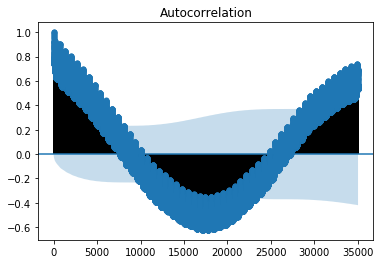

In [142]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_national_i.Consommation, lags=4*24*365)
plt.show()

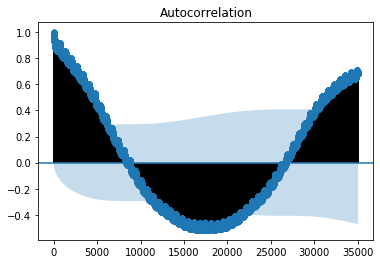

In [143]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_national_i.Nucléaire, lags=4*24*365)
plt.show()

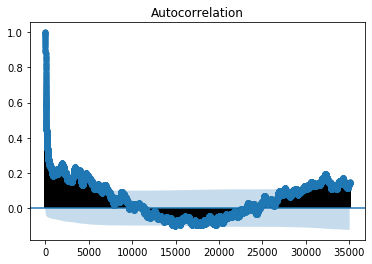

In [144]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_national_i.Eolien, lags=4*24*365)
plt.show()

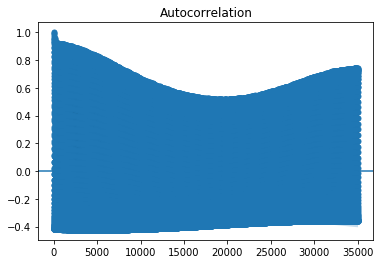

In [146]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_national_i.Solaire, lags=4*24*365)
plt.show()

In [195]:
#Importing price
path='../DATA/Electricity_price/France' # use your path
fichiers = glob.glob(path + "/*.csv")

li = []

for filename in fichiers:
    df = pd.read_csv(filename, sep=',' , encoding='latin_1', index_col = False,na_values='N/A')
    li.append(df)

df_price = pd.concat(li, axis=0, ignore_index=True,sort=False)

def reduce_str(A):
    return A[:16]

df_price['MTU (UTC)']=df_price['MTU (UTC)'].apply(reduce_str)
df_price['MTU (UTC)']=pd.to_datetime(df_price['MTU (UTC)'])
df_price.index=df_price['MTU (UTC)']
df_price.sort_index(inplace=True)
df_price.drop(['MTU (UTC)'],axis=1,inplace=True)
df_price_s=(df_price - df_price.mean()) / (df_price.std())

In [182]:
df_price.head(10)

,Day-ahead Price [EUR/MWh]
MTU (UTC),
2015-01-01 00:00:00,NaN
2015-01-01 01:00:00,NaN
2015-01-01 02:00:00,NaN
2015-01-01 03:00:00,NaN
2015-01-01 04:00:00,NaN
2015-01-01 05:00:00,NaN
2015-01-01 06:00:00,NaN
2015-01-01 07:00:00,NaN
2015-01-01 08:00:00,NaN


In [194]:
#Fichiers nationaux
path='../DATA/data_RTE/conso' # use your path
fichier_nationaux = glob.glob(path + "/eCO2mix_RTE_Annuel-Definitif*.zip")

li = []

for filename in fichier_nationaux:
    df = pd.read_csv(filename, sep='\t' , encoding='latin_1', index_col = False,na_values='ND')
    li.append(df)

df_national_o = pd.concat(li, axis=0, ignore_index=True,sort=False)

df_national_o['Datetime']=df_national_o['Date']+' '+df_national_o['Heures']
df_national_o['Datetime']=pd.to_datetime(df_national_o['Datetime'])
df_national_o.index=df_national_o['Datetime']
df_national_o=df_national_o.drop(['Date', 'Heures','Périmètre','Nature','Datetime'], axis=1)

df_national_o.sort_index(inplace=True)
df_national_o_i = df_national_o.interpolate()
df_national_o_i_s=(df_national_o_i - df_national_o_i.mean()) / (df_national_o_i.std())

<Figure size 432x288 with 0 Axes>

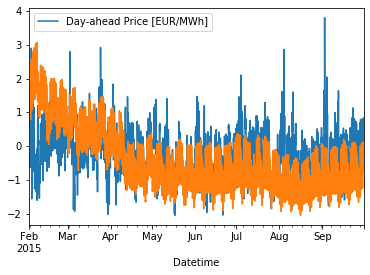

In [202]:
fig=plt.figure()
df_price_s.loc['2015-02':'2015-09'].plot()
df_national_o_i_s.Consommation.loc['2015-02':'2015-09'].plot()
plt.show()

# Etude fréquentielle
https://ipython-books.github.io/101-analyzing-the-frequency-components-of-a-signal-with-a-fast-fourier-transform/

**Note:** <br/>
Cette étude fréquentielle n'est pas propre aux séries temporelles: on peut par exemple chercher des fréquences (motifs) dans une image.


**TODO**
<font color=#cc0066>
        
- Quelles fréquences ressortent de la courbe de consommation ? à quoi correspondent-elles ?
- Tracer le signal obtenu en ne gardant que ces fréquences caractéristiques ? A quel point suffisent-elles pour décrire les variations du signal ?
- Que représentent les hautes fréquences ? Couper les fréquences supérieures à certaines fréquences caractéristiques puis tracer les signaux obtenus.
    
</font>

# Etude des consommations

**TODO**
<font color=#cc0066>
        
- Tracer les consommations des différentes années les une sur les autres
- Tracer toute les consomations journalières les une sur les autres, pour faire apparaitre des différences de comportement entre: jours de semaine et weekend, jours d'été et d'hiver
    
</font>

# Questions bonus

**TODO**
<font color=#cc0066>
        
- Comment estimer très simplement la consommation du lendemain ? quelle erreur commet-on ?
- Estimer le taux de production solaire + éolienne dans les années à venir
- Y a-t-il une saisonnalité dans les moyens de productions ?
- Y-a-il une saisonnalité dans les échanges commerciaux entre la France et ses voisins ?
- quelles types de centrale permettent des changements de production rapides ?
    
</font>